In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import cross_validation as cv
from sklearn.mixture import GaussianMixture as gm

C:\Program Files\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def gauss_function(x, amp, x0, sigma):
    return amp * np.exp(-(x - x0) ** 2. / (2. * sigma ** 2.))

In [3]:
def normalizuj(X):
    X_mean = np.mean(X, axis = 0)
    X_std = np.std(X,axis = 0)
    X_std[(X_std == 0)] = 1
    return ((X - X_mean) / X_std)
def calka(a, b, gmm, eps):
    x = np.arange(a, b + eps, eps)
    n = x.size
    y = np.exp(gmm.score_samples(x.reshape(-1, 1)))
    return np.sum(y[:n-1] + y[1:])*(b-a)/n/2
def calkaBezDzielenia(a, b, gmm, eps):
    x = np.arange(a, b + eps, eps)
    n = x.size
    y = np.exp(gmm.score_samples(x.reshape(-1, 1)))
    return np.sum(y[:n-1] + y[1:])
def obieCalki(a, b, gmm, eps):
    x = np.arange(a, b + eps, eps)
    n = x.size
    y = np.exp(gmm.score_samples(x.reshape(-1, 1)))
    wynik = np.sum(y[:n-1] + y[1:])
    return wynik, wynik*(b-a)/n/2

In [4]:
daneS = 'OrderBookSnapshots.csv';
with open(daneS, 'r') as f:
    dane = f.readlines()

In [5]:
class LOB:
    def __init__(self, wiersz):
        self.zmiana = 0
        self.dzien = wiersz[0]
        self.czas = wiersz[1]
        i = 3
        while (wiersz[i] != 'ASK'):
            i += 1
        bid = wiersz[3:i]
        ask = wiersz[(i+1):]
        self.bid = np.zeros((int((len(bid) / 2)), 2))
        self.ask = np.zeros((int((len(ask) / 2)), 2))
        for i in range(0, len(bid), 2):
            self.bid[int(i / 2)][0] = float(bid[i]) 
            self.bid[int(i / 2)][1] = float(bid[i+1])
        for i in range(0, len(ask), 2):
            self.ask[int(i / 2)] = [float(ask[i]), float(ask[i+1])]
        self.midPrice = (self.bid[len(self.bid) - 1][0] + self.ask[0][0]) / 2
    def __str__(self):
        return "Dzień: " + self.dzien + ", Czas: " + self.czas + ", midPrice: " + str(self.midPrice)

In [6]:
X = []
X1 = []
X2 = []
X3 = []
X4 = []
for wiersz in dane:
    newWiersz = wiersz.split()
    X.append(LOB(newWiersz))
    X1.append(LOB(newWiersz))
    X2.append(LOB(newWiersz))
    X3.append(LOB(newWiersz))
    X4.append(LOB(newWiersz))
X = np.array(X)
X1 = np.array(X1)
X2 = np.array(X2)
X3 = np.array(X3)
X4 = np.array(X4)

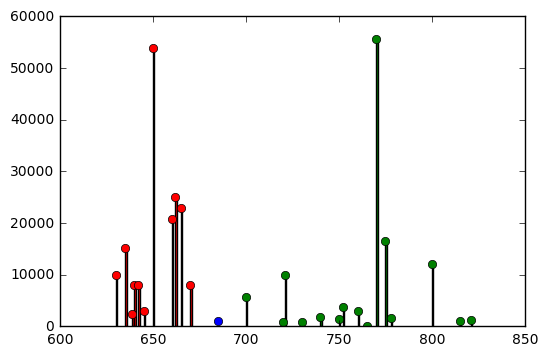

In [7]:
plt.bar(X[0].bid[:, 0], X[0].bid[:, 1], color = 'red')
plt.plot(X[0].bid[:, 0], X[0].bid[:, 1], 'ro')
plt.bar(X[0].ask[:, 0], X[0].ask[:, 1], color = 'green')
plt.plot(X[0].ask[:, 0], X[0].ask[:, 1], 'go')
plt.plot(X[0].midPrice, 1000, "bo")
plt.show()

In [8]:
# ustawianie wartości zmian i tworzenie dla nich osobnego wektora
def generujZmiane(X):
    for i in range(len(X) - 1):
        if (X[i].midPrice > X[i + 1].midPrice):
            X[i].zmiana = 1
        if (X[i].midPrice < X[i + 1].midPrice):
            X[i].zmiana = -1
        if (X[i].midPrice == X[i + 1].midPrice):
            X[i].zmiana = 0
    T = generujIndeksy(X)
    return np.array([i.zmiana for i in X])[T]

# interesują nas te loby, po którch nastąpiła zmiana mid price
def generujIndeksy(X):
    return np.arange(len(X))[np.array([(i.zmiana != 0) for i in X])]

# pierwszy sposób - imbalance to różnica najlepszego bid'a i ask'a przez ich sumę
def generujImbalance1(X):
    T = generujIndeksy(X)
    i = 0
    Imbalance1 = np.zeros((T.shape[0], 1))
    for wiersz in X[T]:
        bid = wiersz.bid[-1, 1]
        ask = wiersz.ask[0, 1]
        Imbalance1[i] = (bid - ask) / (bid + ask)
        i += 1
    return Imbalance1

In [9]:
zmiana = generujZmiane(X)
Imbalance1 = generujImbalance1(X)

In [10]:
indeksy = generujIndeksy(X)

In [11]:
changesPercentage = (zmiana.size / X.size)
print(changesPercentage)

0.8498355864084765


In [12]:
minimum = 100000
maksimum = 0
for wiersz in X:
    bid = wiersz.bid[0, 0]
    ask = wiersz.ask[-1, 0]
    if(ask > maksimum):
        maksimum = ask
    if(bid < minimum):
        minimum = bid
liczbaWspolrzednych = int((maksimum - minimum) * 10 + 1)
tablica = np.zeros((len(X), liczbaWspolrzednych), dtype=int)
i = 0
for wiersz in X:
    for item in wiersz.bid:
        tablica[i][int((item[0] - minimum)*10)] = int(-item[1])
    for item in wiersz.ask:
        tablica[i][int((item[0] - minimum)*10)] = int(item[1])
    i += 1

In [13]:
def generujPrzedzialy(X, tablica, k, il):
    wynik = np.zeros((len(X), 2 * il))
    i = 0
    for wiersz in X:
        pozMidPrice = int((wiersz.midPrice - minimum) * 10)
        for j in range(il):
            if (pozMidPrice - (j+1) * k >= 0):
                wynik[i][2 * j] = np.sum(tablica[i][(pozMidPrice - (j+1) * k): (pozMidPrice - j * k)])
            else:
                wynik[i][2 * j] = 0
            if (pozMidPrice + (j+1) * k < tablica.shape[1]):
                wynik[i][2 * j + 1] = np.sum(tablica[i][(pozMidPrice + j * k): (pozMidPrice + (j+1) * k)])
            else:
                wynik[i][2 * j + 1] = 0;
        i += 1
    return wynik

In [14]:
forMM = []
for i in range(X.size):
    oneLine = []
    for ask in X[i].ask:
        oneLine.extend([ask[0] for j in range(int(ask[1]/100))])
    for bid in X[i].bid:
        oneLine.extend([bid[0] for j in range(int(bid[1]/100))])
    forMM.append(oneLine)

In [15]:
gmmList = []
gmm = gm(n_components=30, n_init=10, covariance_type="full", warm_start = True, tol = 0.001)
for oneLine in forMM:
    gmm.fit(X=np.expand_dims(oneLine, 1))
    gmmList.append(copy.deepcopy(gmm))

In [16]:
tablicaCalekPo1 = np.zeros((X.size, 400))
tablicaCalekPo1BezDzielenia = np.zeros((X.size, 400))
# parzyste to na prawdo od mid
przedzial = 1
for k in range(X.size):
    mid = X[k].midPrice
    for i in range(400):
        a = 0
        b = 0
        if (i%2 == 0):
            a = mid + int(i/2)
            b = a + przedzial
        else:
            b = mid - int(i/2)
            a = b - przedzial
        tablicaCalekPo1BezDzielenia[k][i], tablicaCalekPo1[k][i] = obieCalki(a, b, gmmList[k], 0.001)

In [17]:
tablicaTickowPo1 = generujPrzedzialy(X, tablica, 10, 200)

In [42]:
def generujPrzedzialyRosnace(tablica, il):
    wynik = np.zeros((len(tablica), 2 * il))
    for i in range(len(tablica)):
        a = 0
        b = 1
        for where in range(il):
            for j in range(a, b):
                wynik[i][where*2] += tablica[i][2*j]
                wynik[i][where*2 + 1] += tablica[i][2*j + 1]
            wynik[i][where*2] /= (b-a)
            wynik[i][where*2 + 1] /= (b-a)
            a = b
            b += where + 1
    return wynik

In [43]:
il = 20
tablicaTickowRosnaca = generujPrzedzialyRosnace(tablicaTickowPo1, il)
tablicaCalekRosnaca = generujPrzedzialyRosnace(tablicaCalekPo1, il)

In [45]:
il = 20
tablicaCalekRosnacaBezDzielenia = generujPrzedzialyRosnace(tablicaCalekPo1BezDzielenia, il)

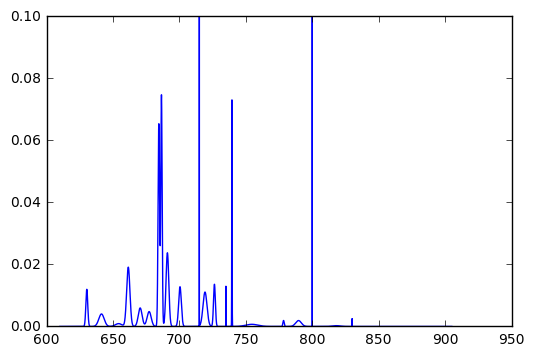

In [20]:
x = forMM[5]

gmm = gm(n_components=30, n_init=10, covariance_type="full", warm_start = True, tol = 0.001)
gmm.fit(X=np.expand_dims(x, 1))

minimalne = X[5].bid[0][0]-5
maksymalne = X[5].ask[-1][0]+5
gmm_x = np.linspace(minimalne, maksymalne, 10000)
gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1, 1)))
plt.ylim(0,0.1)
plt.plot(gmm_x, gmm_y)
plt.savefig("przykladowyWykresGausowski1")
plt.show()

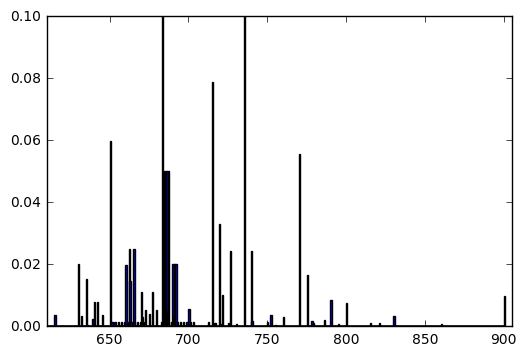

In [21]:
plt.bar([i*0.1 + minimum for i in range(tablica.shape[1])], np.abs(tablica[5]) / 1000000)
plt.xlim(X[5].bid[0][0]-5, X[5].ask[-1][0]+5)
plt.ylim(0,0.1)
plt.savefig("przykladowyWykresHistogram1")
plt.show()

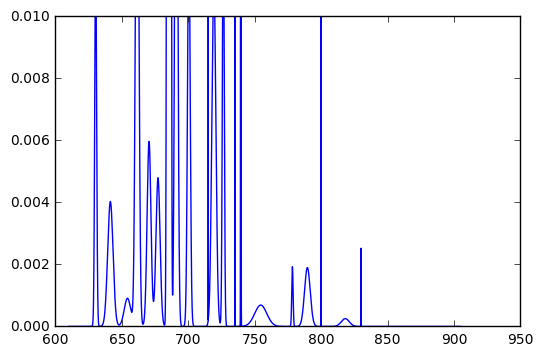

In [22]:
plt.ylim(0,0.01)
plt.plot(gmm_x, gmm_y)
plt.savefig("przykladowyWykresGausowski01")
plt.show()

In [23]:
def testujDecisionFunction(X_test, y_test, kdy, clf):
    wynik = clf.decision_function(X_test).reshape(y_test.shape)
    y_test1 = y_test > 0
    if (kdy[1]):
        return np.sum((wynik > kdy[0]) == y_test1) / y_test.shape[0]
    return np.sum((wynik < kdy[0]) == y_test1) / y_test.shape[0]

def kiedy(X_train, y_train1, poczym):
    tablicawynikow = []
    for i in range(poczym.shape[0]):
        wy = np.sum((poczym < poczym[i]) == y_train1) / y_train1.shape[0]
        tablicawynikow.append(wy)
        wy = np.sum((poczym > poczym[i]) == y_train1) / y_train1.shape[0]
        tablicawynikow.append(wy)
    gdzie = np.argmax(tablicawynikow)
    kdy = (0, 0)
    if (gdzie % 2 == 0):
        return (poczym[int(gdzie/2)], 0)
    else:
        return (poczym[int(gdzie/2)], 1)

def crossValidation(clf, data, dataClass, k):
    size = data.shape[0]
    arr = np.arange(size)
    np.random.shuffle(arr)
    err = 0
    n = int(size / k)
    for i in range(k):
        mask2 = arr[np.arange(i*n,min((i+1)*n,size))]
        mask1 = arr[np.concatenate((np.arange(i*n),np.arange((i+1)*n,size)))]
        X_train = data[mask1]
        y_train = dataClass[mask1]
        X_test = data[mask2]
        y_test = dataClass[mask2]  
        clf = clf.fit(X_train, y_train)
        if isinstance(clf, GridSearchCV):
            clf = clf.best_estimator_
        y_train = y_train.reshape((y_train.shape[0], 1))
        poczym = clf.decision_function(X_train).reshape(y_train.shape)
        y_train1 = y_train > 0;
        nana = kiedy(X_train, y_train1, poczym)        
        err += testujDecisionFunction(X_test, y_test, nana, clf)
    return float(err) / k 

In [24]:
param_grid = {'C': [1, 1e1, 1e2, 1e3, 1e4],
              'gamma': [0.0001, 0.001, 0.01, 0.1], 
             }
svm = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, n_jobs = 6)

In [576]:
print("Cross-Vall score:", crossValidation(svm, tablica[indeksy], zmiana, 2))

Cross-Vall score: 0.5010748065348237


In [578]:
print("tablicaCalekPo1, Cross-Vall score:", crossValidation(svm, tablicaCalekPo1[indeksy], zmiana, 5))

tablicaCalekPo1, Cross-Vall score: 0.5034408602150537


In [579]:
print("tablicaCalekRosnaca, Cross-Vall score:", crossValidation(svm, tablicaCalekRosnaca[indeksy], zmiana, 5)) 

tablicaCalekRosnaca, Cross-Vall score: 0.489247311827957


In [580]:
print("tablicaTickowPo1, Cross-Vall score:", crossValidation(svm, tablicaTickowPo1[indeksy], zmiana, 5))

tablicaTickowPo1, Cross-Vall score: 0.5010752688172043


In [581]:
print("tablicaTickowRosnaca, Cross-Vall score:", crossValidation(svm, tablicaTickowRosnaca[indeksy], zmiana, 5))

tablicaTickowRosnaca, Cross-Vall score: 0.5010752688172043


In [585]:
print("tablicaCalekPo1*100000, Cross-Vall score:", crossValidation(svm, tablicaCalekPo1[indeksy]*100000, zmiana, 5))

tablicaCalekPo1, Cross-Vall score: 0.5135483870967741


In [586]:
print("tablicaCalekRosnaca*100000, Cross-Vall score:", crossValidation(svm, tablicaCalekRosnaca[indeksy]*100000, zmiana, 5)) 

tablicaCalekRosnaca, Cross-Vall score: 0.5021505376344086


In [587]:
print("tablicaCalekPo1*10000000, Cross-Vall score:", crossValidation(svm, tablicaCalekPo1[indeksy]*10000000, zmiana, 5))

tablicaCalekPo1*10000000, Cross-Vall score: 0.5012903225806452


In [588]:
print("tablicaCalekPo1*100, Cross-Vall score:", crossValidation(svm, tablicaCalekPo1[indeksy]*100, zmiana, 5))

tablicaCalekPo1*100000, Cross-Vall score: 0.518494623655914


In [589]:
print("tablicaCalekPo1*1000, Cross-Vall score:", crossValidation(svm, tablicaCalekPo1[indeksy]*1000, zmiana, 5))

tablicaCalekPo1*1000, Cross-Vall score: 0.5232258064516129


In [594]:
print("tablicaCalekPo1*1000, Cross-Vall score:", crossValidation(svm, (((tablicaCalekPo1[indeksy]).T[:200]).T)*1000, zmiana, 5))


tablicaCalekPo1*1000, Cross-Vall score: 0.5326881720430108


In [595]:
print("tablicaCalekPo1*1000, Cross-Vall score:", crossValidation(svm, (((tablicaCalekPo1[indeksy]).T[:100]).T)*1000, zmiana, 5))


tablicaCalekPo1*1000, Cross-Vall score: 0.5350537634408602


In [596]:
for i in (np.arange(10, 110, 10)):
    print("tablicaCalekPo1*1000, zredukowana do ", i, " kolumn, Cross-Vall score:", crossValidation(svm, (((tablicaCalekPo1[indeksy]).T[:i]).T)*1000, zmiana, 5))


tablicaCalekPo1*1000, zredukowana do  10  kolumn, Cross-Vall score: 0.5055913978494624
tablicaCalekPo1*1000, zredukowana do  20  kolumn, Cross-Vall score: 0.5075268817204301
tablicaCalekPo1*1000, zredukowana do  30  kolumn, Cross-Vall score: 0.5281720430107527
tablicaCalekPo1*1000, zredukowana do  40  kolumn, Cross-Vall score: 0.5313978494623657
tablicaCalekPo1*1000, zredukowana do  50  kolumn, Cross-Vall score: 0.5270967741935484
tablicaCalekPo1*1000, zredukowana do  60  kolumn, Cross-Vall score: 0.5105376344086021
tablicaCalekPo1*1000, zredukowana do  70  kolumn, Cross-Vall score: 0.5182795698924731
tablicaCalekPo1*1000, zredukowana do  80  kolumn, Cross-Vall score: 0.5275268817204302
tablicaCalekPo1*1000, zredukowana do  90  kolumn, Cross-Vall score: 0.513763440860215
tablicaCalekPo1*1000, zredukowana do  100  kolumn, Cross-Vall score: 0.5283870967741935


In [597]:
tablicaCalekPo1Znormalizowana = normalizuj(tablicaCalekPo1)

In [599]:
print("tablicaCalekPo1*1000, Cross-Vall score:", crossValidation(svm, (((tablicaCalekPo1Znormalizowana[indeksy]).T[:200]).T)*1000, zmiana, 5))


tablicaCalekPo1*1000, Cross-Vall score: 0.5036559139784946


In [601]:
print("tablicaCalekPo1*1000, Cross-Vall score:", crossValidation(svm, (((tablicaCalekPo1Znormalizowana[indeksy]).T[:40]).T), zmiana, 5))


tablicaCalekPo1*1000, Cross-Vall score: 0.5116129032258063


In [ ]:
print("tablicaCalekPo1*1000, zredukowana do ", i, " kolumn, Cross-Vall score:", crossValidation(svm, (((tablicaCalekPo1BezDzielenia[indeksy]).T[:100]).T), zmiana, 5))


In [27]:
def wyliczCViWypisz(nazwa, tablica, mnoznik, liczbaKolumn, iloscIteracji):
    if mnoznik != 1:
        nazwa += '*' + str(mnoznik)
    wynik = crossValidation(svm, (((tablica[indeksy]).T[:liczbaKolumn]).T)*mnoznik, zmiana, iloscIteracji)
    print(nazwa, "zredukowana do ", liczbaKolumn, " kolumn, Cross-Vall score: ", wynik)

In [617]:
wyliczCViWypisz("tablicaCalekPo1", tablicaCalekPo1, 1000, 100, 10)

tablicaCalekPo1*1000 zredukowana do  100  kolumn, Cross-Vall score:  0.5283870967741935


In [618]:
wyliczCViWypisz("tablicaCalekPo1BezDzielenia", tablicaCalekPo1BezDzielenia, 1, 100, 10)

tablicaCalekPo1BezDzielenia zredukowana do  100  kolumn, Cross-Vall score:  0.5204301075268817


In [28]:
i = 80
wyliczCViWypisz("tablicaCalekPo1", tablicaCalekPo1, 1000, i, 10)
wyliczCViWypisz("tablicaCalekPo1BezDzielenia", tablicaCalekPo1BezDzielenia, 1, i, 10)

tablicaCalekPo1*1000 zredukowana do  80  kolumn, Cross-Vall score:  0.5316129032258063
tablicaCalekPo1BezDzielenia zredukowana do  80  kolumn, Cross-Vall score:  0.5365591397849463


In [29]:
i = 90
wyliczCViWypisz("tablicaCalekPo1", tablicaCalekPo1, 1000, i, 10)
wyliczCViWypisz("tablicaCalekPo1BezDzielenia", tablicaCalekPo1BezDzielenia, 1, i, 10)

tablicaCalekPo1*1000 zredukowana do  90  kolumn, Cross-Vall score:  0.5251612903225806
tablicaCalekPo1BezDzielenia zredukowana do  90  kolumn, Cross-Vall score:  0.5225806451612903


In [30]:
i = 100
wyliczCViWypisz("tablicaCalekPo1", tablicaCalekPo1, 1000, i, 10)
wyliczCViWypisz("tablicaCalekPo1BezDzielenia", tablicaCalekPo1BezDzielenia, 1, i, 10)

tablicaCalekPo1*1000 zredukowana do  100  kolumn, Cross-Vall score:  0.5232258064516129
tablicaCalekPo1BezDzielenia zredukowana do  100  kolumn, Cross-Vall score:  0.5296774193548387


In [31]:
i = 110
wyliczCViWypisz("tablicaCalekPo1", tablicaCalekPo1, 1000, i, 10)
wyliczCViWypisz("tablicaCalekPo1BezDzielenia", tablicaCalekPo1BezDzielenia, 1, i, 10)

tablicaCalekPo1*1000 zredukowana do  110  kolumn, Cross-Vall score:  0.5270967741935485
tablicaCalekPo1BezDzielenia zredukowana do  110  kolumn, Cross-Vall score:  0.5249462365591397


In [32]:
i = 120
wyliczCViWypisz("tablicaCalekPo1", tablicaCalekPo1, 1000, i, 10)
wyliczCViWypisz("tablicaCalekPo1BezDzielenia", tablicaCalekPo1BezDzielenia, 1, i, 10)

tablicaCalekPo1*1000 zredukowana do  120  kolumn, Cross-Vall score:  0.5283870967741935
tablicaCalekPo1BezDzielenia zredukowana do  120  kolumn, Cross-Vall score:  0.5197849462365591


In [33]:
i = 130
wyliczCViWypisz("tablicaCalekPo1", tablicaCalekPo1, 1000, i, 10)
wyliczCViWypisz("tablicaCalekPo1BezDzielenia", tablicaCalekPo1BezDzielenia, 1, i, 10)

tablicaCalekPo1*1000 zredukowana do  130  kolumn, Cross-Vall score:  0.5294623655913978
tablicaCalekPo1BezDzielenia zredukowana do  130  kolumn, Cross-Vall score:  0.5298924731182796


In [34]:
i = 140
wyliczCViWypisz("tablicaCalekPo1", tablicaCalekPo1, 1000, i, 10)
wyliczCViWypisz("tablicaCalekPo1BezDzielenia", tablicaCalekPo1BezDzielenia, 1, i, 10)

tablicaCalekPo1*1000 zredukowana do  140  kolumn, Cross-Vall score:  0.5195698924731182
tablicaCalekPo1BezDzielenia zredukowana do  140  kolumn, Cross-Vall score:  0.5277419354838708


In [35]:
i = 150
wyliczCViWypisz("tablicaCalekPo1", tablicaCalekPo1, 1000, i, 10)
wyliczCViWypisz("tablicaCalekPo1BezDzielenia", tablicaCalekPo1BezDzielenia, 1, i, 10)

tablicaCalekPo1*1000 zredukowana do  150  kolumn, Cross-Vall score:  0.5238709677419354
tablicaCalekPo1BezDzielenia zredukowana do  150  kolumn, Cross-Vall score:  0.5204301075268817


In [36]:
i = 160
wyliczCViWypisz("tablicaCalekPo1", tablicaCalekPo1, 1000, i, 10)
wyliczCViWypisz("tablicaCalekPo1BezDzielenia", tablicaCalekPo1BezDzielenia, 1, i, 10)

tablicaCalekPo1*1000 zredukowana do  160  kolumn, Cross-Vall score:  0.5324731182795698
tablicaCalekPo1BezDzielenia zredukowana do  160  kolumn, Cross-Vall score:  0.529032258064516


In [37]:
i = 170
wyliczCViWypisz("tablicaCalekPo1", tablicaCalekPo1, 1000, i, 10)
wyliczCViWypisz("tablicaCalekPo1BezDzielenia", tablicaCalekPo1BezDzielenia, 1, i, 10)

tablicaCalekPo1*1000 zredukowana do  170  kolumn, Cross-Vall score:  0.5260215053763441
tablicaCalekPo1BezDzielenia zredukowana do  170  kolumn, Cross-Vall score:  0.5372043010752688


In [38]:
i = 180
wyliczCViWypisz("tablicaCalekPo1", tablicaCalekPo1, 1000, i, 10)
wyliczCViWypisz("tablicaCalekPo1BezDzielenia", tablicaCalekPo1BezDzielenia, 1, i, 10)

tablicaCalekPo1*1000 zredukowana do  180  kolumn, Cross-Vall score:  0.5326881720430108
tablicaCalekPo1BezDzielenia zredukowana do  180  kolumn, Cross-Vall score:  0.5301075268817204


In [39]:
i = 190
wyliczCViWypisz("tablicaCalekPo1", tablicaCalekPo1, 1000, i, 10)
wyliczCViWypisz("tablicaCalekPo1BezDzielenia", tablicaCalekPo1BezDzielenia, 1, i, 10)

tablicaCalekPo1*1000 zredukowana do  190  kolumn, Cross-Vall score:  0.5268817204301075
tablicaCalekPo1BezDzielenia zredukowana do  190  kolumn, Cross-Vall score:  0.5331182795698924


In [40]:
i = 200
wyliczCViWypisz("tablicaCalekPo1", tablicaCalekPo1, 1000, i, 10)
wyliczCViWypisz("tablicaCalekPo1BezDzielenia", tablicaCalekPo1BezDzielenia, 1, i, 10) 

tablicaCalekPo1*1000 zredukowana do  200  kolumn, Cross-Vall score:  0.5260215053763441
tablicaCalekPo1BezDzielenia zredukowana do  200  kolumn, Cross-Vall score:  0.5305376344086021


In [41]:
i = 80
wyliczCViWypisz("tablicaCalekPo1BezDzielenia", normalizuj(tablicaCalekPo1BezDzielenia), 1, i, 10)
wyliczCViWypisz("tablicaCalekPo1BezDzielenia", normalizuj(tablicaCalekPo1BezDzielenia.T).T, 1, i, 10)

tablicaCalekPo1BezDzielenia zredukowana do  80  kolumn, Cross-Vall score:  0.5131182795698925
tablicaCalekPo1BezDzielenia zredukowana do  80  kolumn, Cross-Vall score:  0.5337634408602151


In [44]:
i = 80
wyliczCViWypisz("tablicaCalekRosnaca", tablicaCalekRosnaca, 1, i, 10)
wyliczCViWypisz("tablicaCalekRosnaca", tablicaCalekRosnaca, 1000, i, 10)
wyliczCViWypisz("tablicaTickowRosnaca", tablicaTickowRosnaca, 1, i, 10)


tablicaCalekRosnaca zredukowana do  80  kolumn, Cross-Vall score:  0.5017204301075269
tablicaCalekRosnaca*1000 zredukowana do  80  kolumn, Cross-Vall score:  0.5292473118279569
tablicaTickowRosnaca zredukowana do  80  kolumn, Cross-Vall score:  0.5010752688172043


In [46]:
i = 80
wyliczCViWypisz("tablicaCalekRosnacaBezDzielenia", tablicaCalekRosnacaBezDzielenia, 1, i, 10)

tablicaCalekRosnacaBezDzielenia zredukowana do  80  kolumn, Cross-Vall score:  0.5187096774193549


In [ ]:
for i in range(10, 250, 5):
    k = 20
    wyliczCViWypisz("tablicaCalekPo1", tablicaCalekPo1, 1000, i, k)
    wyliczCViWypisz("tablicaCalekPo1BezDzielenia", tablicaCalekPo1BezDzielenia, 1, i, k)
    wyliczCViWypisz("tablicaCalekRosnaca", tablicaCalekRosnaca, 1000, i, k)
    wyliczCViWypisz("tablicaCalekRosnacaBezDzielenia", tablicaCalekRosnacaBezDzielenia, 1, i, k)
    print()

In [47]:
print()